# Astro 304 "Galaxies"
## Distributions of galaxy properties, Malmquist bias, Vmax correction

### Preliminaries: set up plotting parameters

In [29]:
import numpy as np

# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You can turn this notebook into a slide show using nbconvert package:

jupyter-nbconvert --to slides ex03_sdss_galaxies_distributions.ipynb --post serve

### Let's read the fits table with SDSS spectroscopic galaxy sample

In [30]:
from code.read_sdss_fits import read_sdss_fits
from code.setup.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

In [31]:
import numpy as np

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does 
# not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster ~16 Mpc away from the Milky Way
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 1.0

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 12.0; m_max = 17.77

# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
cmr = data['cmodelMag_r'] - data['extinction_r']
cmg = data['cmodelMag_g'] - data['extinction_g']
gr = cmg - cmr

# apply redshift, magnitude, and color cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-2.5) & (gr<2.5)]

print("selected %d galaxies"%np.shape(data['z']))


selected 650045 galaxies


### Compute various useful properties for SDSS galaxies

In [39]:
# now compute luminosity and angular diameter distances for galaxies in the sample
from code.cosmology import d_l
# define suitable cosmological parameters
# mean matter and vacuum energy densities in units of the critical density 
Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

z = data['z']

d_L = d_l(z, Om0, OmL, ninter=20)
d_A = d_L / (1.+z)**2

# dimensionless distance -> Mpc 
d_L *= d_H / h; d_A *= d_H /h 

# Petrosian and cmodel magnitudes in the r band, extinction corrected. 
mpetro = data['petroMag_r'] - data['extinction_r']
mcmodel = data['cmodelMag_r'] - data['extinction_r']

# cmodel and Petrosian absolute magnitudes in the r-band
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5)
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5)

# now account for evolution and apply K-correction

# g-r color for computing K-correction using cmodel magnitudes
gr = data['cmodelMag_g'] - data['extinction_g'] - data['cmodelMag_r'] + data['extinction_r']

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not designed for z>0.6, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

Mcmodel = Mcmodel - kcorr 
Mpetro  = Mpetro - kcorr

# finally, compute log10 of r-band luminosity in Lsun,r from the cmodel and Petrosian absolute mmagnitudes
Lcmodel =  0.4*(4.67-Mcmodel)
Lpetro =  0.4*(4.67-Mpetro)

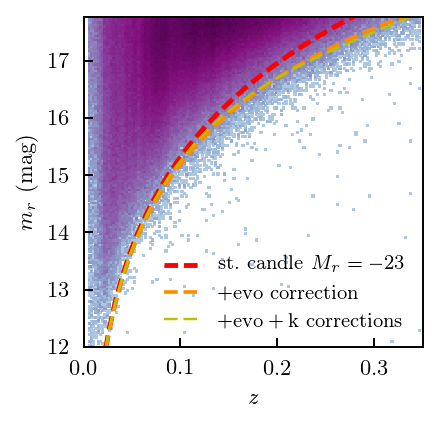

In [37]:
from code.plot_utils import plot_2d_dist, plot_mz

z = data['z']
mr = data['petroMag_r'] - data['extinction_r']

# plot m-z diagram
zlim = [0.0, 0.35]; mrlim = [m_min, m_max]

plot_mz(z, mr, xlim=zlim, ylim=mrlim, nxbins=151, nybins=151, 
        xlabel=r'$z$', ylabel=r'$m_{r}\ \mathrm{(mag)}$', Om0=0.3, OmL=0.7, h=0.7, 
        savefig='fig/mappz_sdss.png')


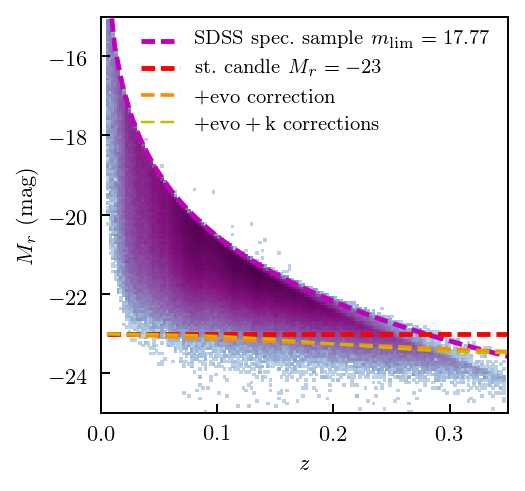

In [38]:
from code.plot_utils import plot_Mz

Mrlim = [-25,-15.]
plot_Mz(z, Mpetro,  xlim=zlim, ylim=Mrlim, nxbins=151, nybins=151, 
        xlabel=r'$z$', ylabel=r'$M_{r}\ \mathrm{(mag)}$', 
        Om0 = 0.3, OmL = 0.7, h = 0.7, 
        savefig='fig/Mabsz_sdss.png')

### The Malmquist bias

The apparent magnitude limit of the SDSS spectroscopic galaxy sample ($m_{r, \rm Petro}<17.77$) imposes a severe limitation in our ability to study properties of the faintest galaxies, as it limits the faint sample to only the nearest redshifts (i.e., a small volume). At the same time, as we can see from the figures above, at $z\lesssim 0.05$ we don't have a sufficiently large number of bright galaxies to probe the bright end of the distribution reliably.

We can get a good number of bright galaxies if we include galaxies with redshifts $z>0.05$, but then we 
 are incomplete at faint magnitudes. This difficulty is a manifestation of the <b>Malmquist bias</b> (<a href="http://adsabs.harvard.edu/abs/1922MeLuF.100....1M">Malmquist 1922</a>) -- the fact that only the brightest objects are visible at large distances for a flux (or magnitude) limited sample. If one is not careful, bright, distant galaxies will dominate the sample.  
 
The Malmquist bias is the reason why while scanning the Google Sky bright spheroidal galaxies seem to be most common. The brightest galaxies in the universe are predominantly spheroidal and thus, given the flux limit, we see spheroidal galaxies to largest distances - i.e., over more volume. They then appear to us to be most frequent, even though brightest spheroidal galaxies are actually the rarest galaxies in the universe. 

### $V_{\rm max}$ correction

The most commonly used way to correct for the Malmquist bias is the <b>$V_{\rm max}$ correction</b> (<a href="http://adsabs.harvard.edu/abs/1968ApJ...151..393S">Schmidt 1968</a>, see the beginning of Section VII on p. 403).

$V_{\rm max}$ is the volume within which a given galaxy would be visible given the apparent magnitude limit of the survey, or, in general, a combination of any other selection limits of the sample. 

In the simplest case of a simple selection via a magnitude limit, a galaxy of apparent magnitude $m$ at redshift $z$ has absolute magnitude

$$ M = m - 5\log_{10}\left(\frac{d_{\rm L}(z)}{10\,\rm pc}\right)$$
and would be visible out to $d_{\rm L, max}$ defined by 

$$
M = m_{\rm lim} - 5\log_{10}\left(\frac{d_{\rm L,max}}{10\,\rm pc}\right)
$$
for a survey with apparent magnitude limit, $m_{\rm lim}$,
or (converting to Megaparsecs, i.e. $10\,\rm pc= 10^{-5}\ Mpc$):

$$
d_{\rm L,max}=10^{-5}\, 10^{0.2(m_{\rm lim}-M)}\ \rm Mpc.
$$

### $V_{\rm max}$ correction contd.

Because we use magnitudes, the maximum distance we obtain is the luminosity distance. However, to compute comoving volume, we need transverse comoving distance: $d_{M,\rm max}=d_{L,\rm max}/(1+z)$ (see ex01 notebook and Appendix A in the notes). For flat cosmology ($\Omega_{\rm m0}+\Omega_\Lambda=1$), which we will usually be assuming, transverse comoving distance is equal to the line of sight comoving distance, $d_M=d_c$ and the maximum volume is computed using usual Eucledian expression:   

$$
V_{\rm max} = \frac{\Omega}{3}\, d_{M, \rm max}^3, 
$$
where $\Omega$ is the solid angle covered by the survey on the sky in steradians. If selection also imposes a minimum distance for some reason, then volume should account for that: 

$$
V_{\rm max} = \frac{\Omega}{3}\,\left(d_{M,\rm max}^3-d_{M,\rm min}^3\right). 
$$

Once we have $V_{\rm max}$ for every galaxy, we can weigh each galaxy by the $1/V_{\rm max}$, whenever we want to construct a distribution with the correct relative abundances of faint and bright galaxies. 

In [10]:
# compute Vmax for SDSS galaxies

# SDSS DR8 solid angle in steradians, the solid angle of the SDSS spectroscopic survey is 9274 square degrees, see:
# https://www.sdss3.org/dr8/scope.php
solid_angle = 9274.*(np.pi/180)**2

d_Mmax = np.power(10.,0.2*(m_max-Mpetro))/(1.+z)
d_Mmin = np.power(10.,0.2*(m_min-Mpetro))/(1.+z)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxi = 3.0/(d_Mmax**3 - d_Mmin**3)

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
cc = 0.93 
# final 1/Vmax; 
# dividing by solid_angle*cc does not matter for weighting, but matters when luminosity function is computed 
vmaxi = vmaxi / (solid_angle*cc)


In [11]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given distance and absolute magnitude
Mlim = -17.0; Dmax = 1000.
iloc = (Mcmodel < Mlim) & (d_A < Dmax)

# define data file for the local sample
locdata = data[iloc];

# copy properties in easier to use and descriptively named vectors
vmaxiloc = vmaxi[iloc]

# redshift and cmodel absolute magnitude
zl = locdata['z']; M_rl  = Mcmodel[iloc]
# g-r color
grl = gr[iloc]

# half-light Petrosian radius, and radius containing 90% of Petrosian magnitude in arcsec
r50l = locdata['petroR50_r']; r90l = locdata['petroR90_r']; 
# light concentration
crl = r90l / r50l 
# mean surface brightness within r50 in mag per square arcsec
mul = locdata['petroMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50l)**2)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


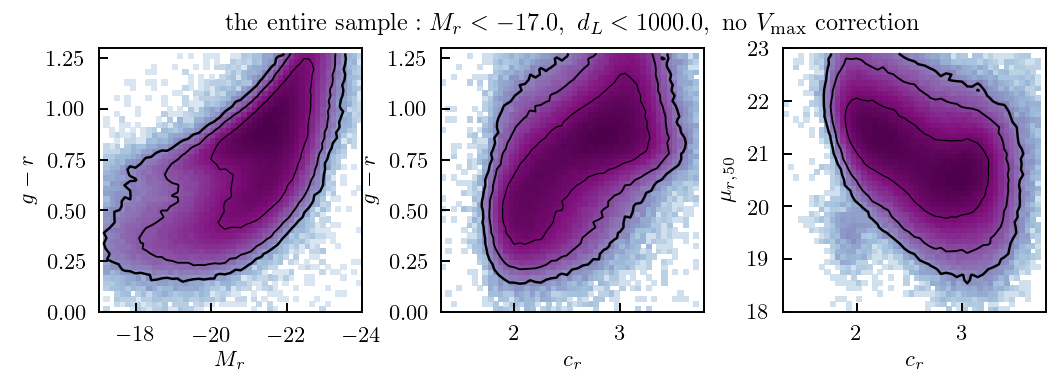

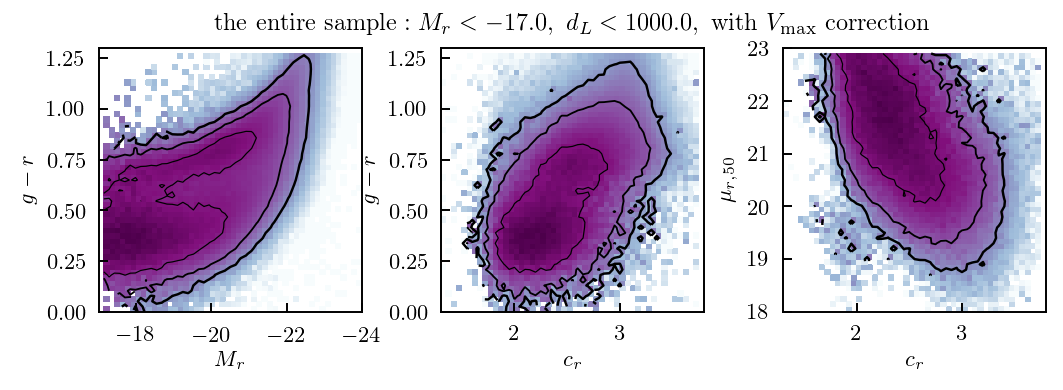

In [13]:
# plot 2D distributions abs. magnitude, color, concentration, and surface brightness within r50
# without Malmquist bias correction

Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = [0.68, 0.95, 0.99]

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f,\ \mathrm{no}\ V_{\rm max}\ \mathrm{correction}$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(M_rl, grl, Mrlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

plot_2d_dist(crl, grl, crlim, grlim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crl, mul, crlim, sblim, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

plt.savefig('fig/colcrmur_nocorr.png',bbox_inches='tight')
plt.show()

# now plot the same with Malmquist bias correction
fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f, \ \mathrm{with}\ V_{\rm max}\ \mathrm{correction}$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(M_rl, grl, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

plot_2d_dist(crl, grl, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crl, mul, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

plt.savefig('fig/colcrmur_corr_Vmax.png',bbox_inches='tight')
plt.show()

### Effects of the Malmquist bias

This and following slides show distribution of the SDSS galaxies in 2D planes of different properties and illustrate the effect of the Malmquist bias. The plot below shows galaxies at all distances and does not correct for the Malmquist bias. 

<img width=1000 src="fig/colcrmur_nocorr.png"></img>

### Effects of the Malmquist bias

The plot below shows galaxies at all distances corrected for the Malmquist bias using the $V_{\rm max}$ correction. 

<img width=1000 src="fig/colcrmur_corr_Vmax.png"></img>

### Galaxy color and its correlations with other properties

<b>Concentration of light.</b> SDSS database provides estimates of the radii (in arcsec) enclosing 50% and 90% of the total light estimated using the <a href="http://adsabs.harvard.edu/cgi-bin/nph-bib_query?bibcode=1976ApJ...209L...1P">Petrosian (1978)</a> profile (so called <a href="http://classic.sdss.org/dr7/algorithms/photometry.html#mag_petro">Petrosian magnitude</a>). Their ratio provides us with a distance-independent measure of (inverse) concentration of galaxy light: $c\equiv R_{50}/R_{90}$. In many studies concentration is used as a "proxy" for traditional morphological types (e.g., <a href="http://adsabs.harvard.edu/abs/2001AJ....122.1861S">Strateva et al. 2001</a>). We will check how concentration correlates with color, surface, brightness, and morphology now. 

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'interpolation'
  s)


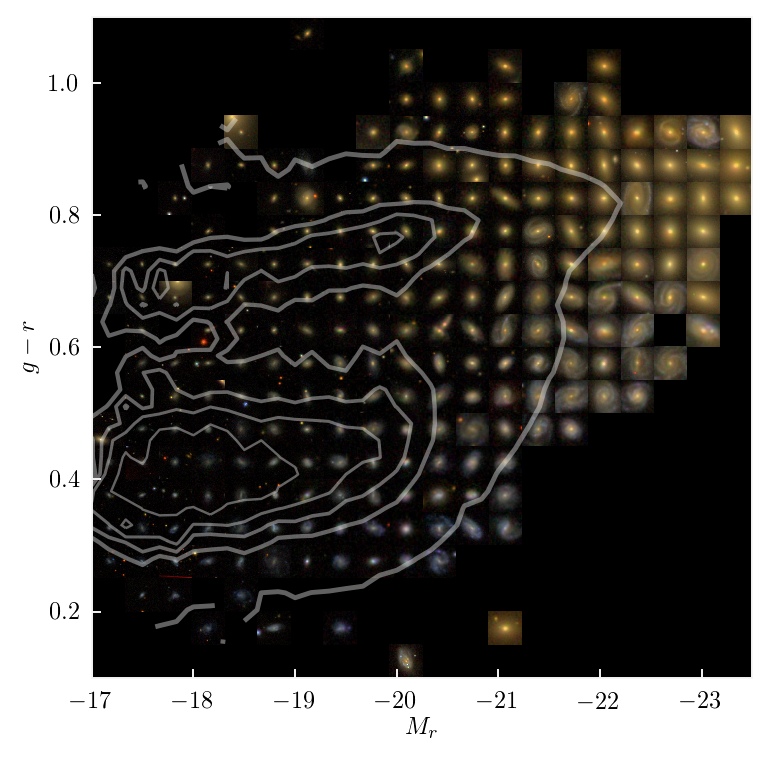

In [14]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

# let's re-select a sample of nearby SDSS galaxies down to a given distance and absolute magnitude
Mlim = -17.0; Dmin = 75.; Dmax = 300.
# weighted estimate of the light axes ratio of galaxy
fracdeV_r = data['fracdeV_r'] 
ab = fracdeV_r*data['deVAB_r'] + (1.0 - fracdeV_r)*data['expAB_r']

iloc = (Mcmodel < Mlim) & (d_A > Dmin) & (d_A < Dmax) & (ab > 0.5)
locdata = data[iloc]; M_rl  = Mcmodel[iloc]
zl = locdata['z']
dAl = d_A[iloc]; vmaxiloc = vmaxi[iloc]
grl = locdata['modelMag_g'] - locdata['modelMag_r'] 

kcorr_g = calc_kcor('g', zl, 'g - r', grl)
kcorr_r = calc_kcor('r', zl, 'g - r', grl)
grl_kcorr = grl - kcorr_g + kcorr_r         
r50l = locdata['petroR50_r']; r90l = locdata['petroR90_r']; 
crl = r90l / r50l 
mul = locdata['petroMag_r'] - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(r50l)**2)


crs = locdata['petroR90_r']/locdata['petroR50_r']
mrs = locdata['petroMag_r']
size = locdata['petroR50_r']
objs = locdata['objID']; ras = locdata['ra']; decs = locdata['dec']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
sbs = mrs - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2)

xlabel = r'$M_r$'; ylabel = r'$g-r$'
nrows = 20; ncols = 20; rnd_seed = 3421
ylims = [0.1,1.1]; xlims = [-23.5,Mlim]
clevs = np.linspace(0.2,0.99,5)
#clevs = [0.68, 0.95, 0.99]
plt.rc('font',size=10)

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=M_rl, ys=grl_kcorr, weights = vmaxiloc,
                               xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               show_axis=True, show_xaxis=True, show_yaxis=True,
                               nrows=nrows, ncols=ncols, npix = 500, 
                               rnd_seed=rnd_seed, kpc_per_npix=25, 
                               clevs = clevs, ncont_bins = 41,
                               dA = dAl, facecolor='black', 
                               outfile='fig/Mrgr_collage.png')



<img width=700 align=left src='fig/Mrgr_collage.png'></img>

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'interpolation'
  s)


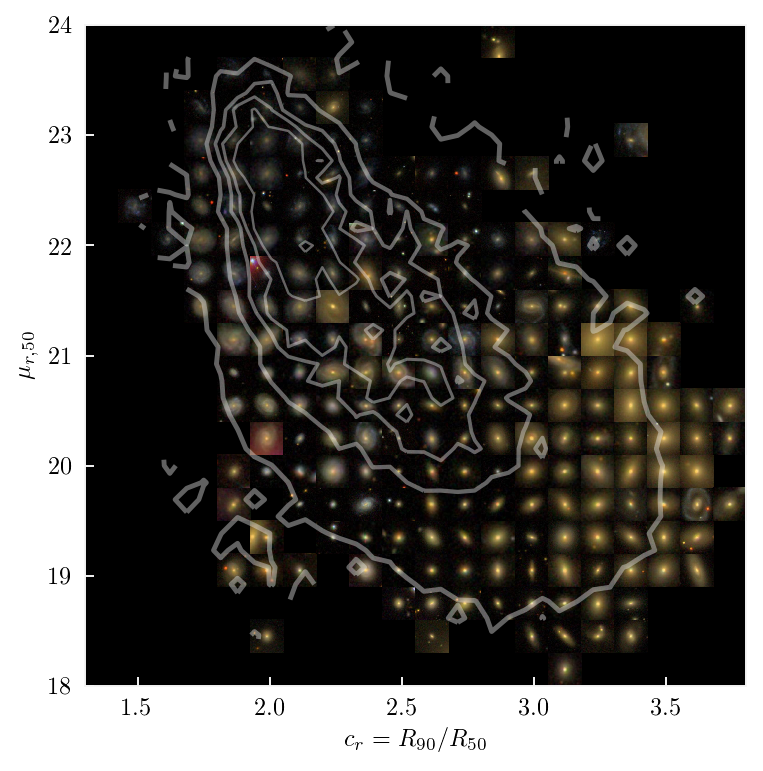

In [16]:
crlim = [1.3,3.8]; sblim = [18., 24.]
xlabel = r'$c_r=R_{90}/R_{50}$'; ylabel = r'$\mu_{r,50}$'
plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=crl, ys=mul - kcorr_r, xlims = crlim, 
                               ylims=sblim, xlab=xlabel, ylab=ylabel, weights = vmaxiloc,
                               nrows=nrows, ncols=ncols, npix = 150, 
                               show_axis=True, show_xaxis=True, show_yaxis=True, facecolor='black',
                               rnd_seed=rnd_seed, clevs = clevs, ncont_bins = 41, dA = dAl, 
                               outfile='fig/crmu_collage.png' ) 

<img width=700 align=left src='fig/crmu_collage.png'></img>

We can see that color, surface brightness, absolute magnitude and concentration do not cleanly separate galaxies of different morphologies on their own. However, there are overall average trends of morphology with these galaxy properties. 

If we look at the above plots, we can see that one big reason for lack of clean separation is the fact that edge-on disks are red and so mix with red spheroidals in the g-r color and they also have high concentration and surface brightness due to projection effect. This suggests that if we add one more quantity that could differentiate edge-on disks from spheroidals we could achieve a relatively clean separation of morphological types. 

<b>Question.</b> What kind of quantity would serve this purpose?